In [150]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.transform import resize
import numpy as np
import torch

In [151]:
# Load Model
from multimodal.multimodal_lit import MultiModalLitModel
from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_name = "cvcl_s_dino_resnext50_embedding" 
checkpoint = hf_hub_download(repo_id="wkvong/"+checkpoint_name, filename=checkpoint_name+".ckpt")
model = MultiModalLitModel.load_from_checkpoint(checkpoint_path=checkpoint)
model = model.to(device)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--wkvong--cvcl_s_dino_resnext50_embedding/snapshots/fe96aa69683bad69e5dd5195fc874a3edb8cb691/cvcl_s_dino_resnext50_embedding.ckpt`


MultiModalLitModel(
  (vision_encoder): VisionEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [152]:
# Hook Features
features = []

def hook_feature(module, input, output):
    features.append(output.data.cpu().numpy())

layers = ['vision_encoder.model.layer1', 'vision_encoder.model.layer2', 'vision_encoder.model.layer3', 'vision_encoder.model.layer4']

for name in layers:
    module = dict(model.named_modules()).get(name)
    if module:
        module.register_forward_hook(hook_feature)
        print(f"Hook registered for layer: {name}")
    else:
        print(f"Warning: Layer {name} does not exist in the model.")

Hook registered for layer: vision_encoder.model.layer1
Hook registered for layer: vision_encoder.model.layer2
Hook registered for layer: vision_encoder.model.layer3
Hook registered for layer: vision_encoder.model.layer4


In [153]:
# Load and convert the image
image = Image.open('road.png')
if image.mode != 'RGB':
    image = image.convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the image
image = preprocess(image)

img_tensor = torch.unsqueeze(image, 0) # Add batch dimension
img_tensor = img_tensor.to(device)

# Net-Dissect Highlights
img_array = np.array(image)


# Foward pass
logit = model.encode_image(img_tensor)


In [155]:
layer = 4
unit = 257

unit_index = unit - 1
layer_index = layer - 1 

# Thresholds from Net-Dissect
quantiles = np.load(f'result/cvcl_ctgr6_lyr4/quantile_{layer_index}.npy')
print(quantiles.shape)
threshold = quantiles[unit_index]
print(f"Thresholds for {unit_index+1} unit: {threshold})")

(2048,)
Thresholds for 257 unit: 5.797868185997191)


In [164]:
features[0].shape

(1, 256, 56, 56)

Feature map shape: (7, 7)
Resized map shape: (224, 224)


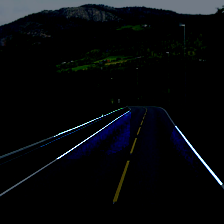

In [156]:
# 提取特征图
unit_feature_map = features[layer_index][0, unit_index, :, :]
print("Feature map shape:", unit_feature_map.shape)

# 将特征图调整到原始图像的空间尺寸（保持为二维）
resized_map = resize(unit_feature_map, image.shape[1:3], mode='reflect', anti_aliasing=True)
print("Resized map shape:", resized_map.shape)

mask = resized_map > threshold

highlighted = img_array.copy()

# 应用变暗操作到非激活区域
highlighted[0, :, :][~mask] *= 0.2
highlighted[1, :, :][~mask] *= 0.2
highlighted[2, :, :][~mask] *= 0.2

highlighted = highlighted.transpose(1, 2, 0)

highlighted = np.clip(highlighted * 255, 0, 255).astype(np.uint8)

highlighted_image = Image.fromarray(highlighted)
highlighted_image.show()

Feature map shape: (7, 7)


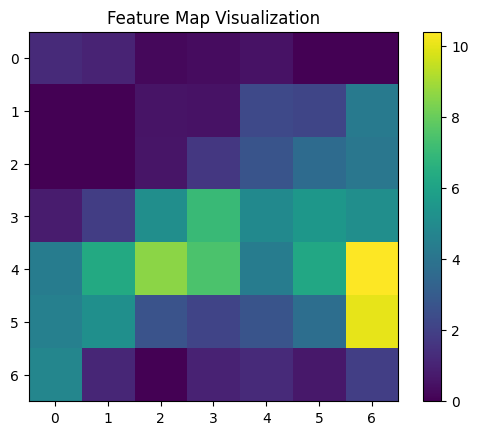

In [157]:
print("Feature map shape:", unit_feature_map.shape)

# 显示特征图
plt.imshow(unit_feature_map, cmap='viridis')  # 使用 viridis 颜色映射，也可以选择其他如 'gray', 'plasma' 等
plt.colorbar()  # 显示颜色条
plt.title("Feature Map Visualization")
plt.show()

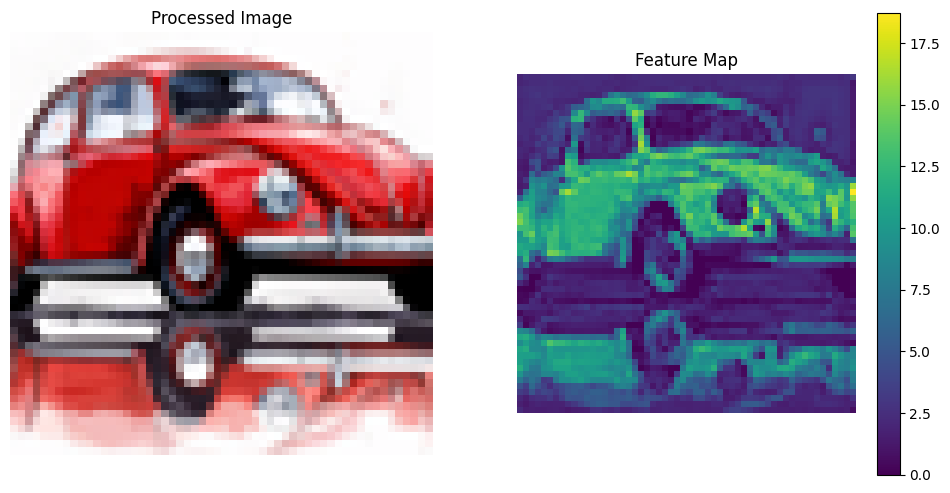

In [158]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch

# 打开图像并确保是 RGB 模式
image = Image.open('red_car.png')
if image.mode != 'RGB':
    image = image.convert('RGB')

# 定义预处理流程
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 对图像进行预处理
tensor_image = preprocess(image)


# 将张量转换回图像格式以便显示
def tensor_to_image(tensor):
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    tensor = tensor.clamp(0, 1)
    tensor = torch.permute(tensor, (1, 2, 0))  # 从 CxHxW 转换为 HxWxC
    return Image.fromarray((tensor.numpy() * 255).astype('uint8'))

processed_image = tensor_to_image(tensor_image)

# 调整处理过的图像尺寸以匹配特征图尺寸
feature_map_size = feature_map.shape  # 假设 feature_map 是一个 (height, width) 形状的数组
processed_image = processed_image.resize((feature_map_size[1], feature_map_size[0]))  # PIL.Image.resize 使用 (width, height)

# 显示原始图像和特征图
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(processed_image)
ax[0].set_title("Processed Image")
ax[0].axis('off')

# 绘制特征图并添加颜色条
feature_map_image = ax[1].imshow(feature_map, cmap='viridis')
ax[1].set_title("Feature Map")
ax[1].axis('off')
fig.colorbar(feature_map_image, ax=ax[1], orientation='vertical')  # 添加颜色条

plt.show()

In [163]:
quantiles = np.load('result/cvcl_ctgr6_lyr4/quantile_2.npy')
print(quantiles.shape)

(1024,)
